In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
import pandas as pd
import random


In [2]:
def svcca(x, y, cutoff=0.99):
    
    u_x, s_x, v_x = torch.svd(x - x.mean(axis=0))
    u_y, s_y, v_y = torch.svd(y - y.mean(axis=0))
    
    var_x = torch.cumsum(s_x**2/torch.sum(s_x**2), dim=0)
    var_y = torch.cumsum(s_y**2/torch.sum(s_y**2), dim=0)
    
    u_1 = u_x[:,:torch.where(var_x > cutoff)[0][0]+1]
    u_2 = u_y[:,:torch.where(var_y > cutoff)[0][0]+1]
    
    s_1 = s_x[:torch.where(var_x > cutoff)[0][0]+1]
    s_2 = s_y[:torch.where(var_y > cutoff)[0][0]+1]
    
    v_1 = v_x[:,:torch.where(var_x > cutoff)[0][0]+1]
    v_2 = v_y[:,:torch.where(var_y > cutoff)[0][0]+1]
    
    uu = u_1.t() @ u_2
    u, diag, v = torch.svd(uu)
    a = (v_1 * s_1.reciprocal_().unsqueeze_(0)) @ u
    b = (v_2 * s_2.reciprocal_().unsqueeze_(0)) @ v
    return a, b, diag

In [217]:
class SineTask:
    def __init__(self):
        self.amplitude = np.random.uniform(0.1, 5.0)
        self.phase = np.random.uniform(0, 2*np.pi)
        self.hold_x = None
        
    def sin(self, x):
        return self.amplitude * np.sin(x + self.phase)
    
    def training_data(self, n=10, fresh = False):
        if self.hold_x is None:
            self.hold_x = np.random.uniform(-5, 5, size=(n,1))
            x = self.hold_x
        else:
            if fresh:
                x = np.random.uniform(-5, 5, size=(n,1))
            else:
                x = self.hold_x
        y = self.sin(x)
        return torch.Tensor(x), torch.Tensor(y)
            
        
    def test_data(self, n=50):
        x = np.linspace(-5, 5, num=n).reshape(n,1)
        y = self.sin(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    
class SineModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(1, 40)
        self.relu1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(40, 40)
        self.relu2 = torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(40, 1)
        self.parameter_dict = {name: par for name, par in self.named_parameters()}
        self.activations_relu1 = []
        self.activations_relu2 = []
        self.activations_layer3 = []
        self.handles = []
    
    def forward(self, x, parameters=None):
        if parameters is None:
            x = self.layer1(x)
            x = self.relu1(x)
            x = self.layer2(x)
            x = self.relu2(x)
            x = self.layer3(x)
            return x
        else:
            x = F.linear(x, parameters['layer1.weight'], parameters['layer1.bias'])
            x = F.relu(x)
            x = F.linear(x, parameters['layer2.weight'], parameters['layer2.bias'])
            x = F.relu(x)
            x = F.linear(x, parameters['layer3.weight'], parameters['layer3.bias'])
            return x
                
    def get_parameter_dict(self):
        self.update_parameter_dict()
        return self.parameter_dict
    
    def get_activations(self, name):
        return getattr(self, 'activations_'+name)
    
    def update_parameter_dict(self):
        self.parameter_dict = {name: par for name, par in self.named_parameters()}

    def copy(self, model):
        self.load_state_dict(model.state_dict())
        
    def set_hooks(self):
        
        def hook_fn(name):
            def hook(model, input, output):
                getattr(self, 'activations_'+name).append(output.detach())
            return hook
            
        for name, module in self.named_modules():
            h = hook_fn(name)
            if name[:-1] == 'relu' or name == 'layer3':
                self.handles.append(getattr(self,name).register_forward_hook(h))
    
    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()
        self.reset_activations()
    
    def reset_activations(self):
        for name, module in self.named_modules():
            if name[:-1] == 'relu' or name == 'layer3':
                getattr(self, 'activations_'+name).clear()

        
class MetaLearning:
    def __init__(self):
        self.meta_model = SineModel()
        self.tuned_model = None
        self.meta_parameters = self.meta_model.get_parameter_dict()
        self.metric = torch.nn.MSELoss()
        self.activation = []
    
    def get_parameters(self): # depreciated
        self.update_meta_parameters()
        return self.meta_parameters
    
    def get_exp_results(self):
        return self.exp_results
    
    def update_meta_parameters(self):
        self.meta_parameters = self.meta_model.get_parameter_dict()
            
    def train(self, epochs=100, num_tasks=25, num_grad_steps=1, meta_lr=1e-3, step_lr=0.01, foa=False, config='maml', exp=False):
        self.epochs = epochs
        self.num_tasks = num_tasks
        self.meta_lr = meta_lr
        self.step_lr = step_lr
        self.foa = foa
        self.config = config
        self.optimizer = torch.optim.Adam(self.meta_model.parameters(), lr=self.meta_lr)
        self.exp_results = []
        
        if exp:
            self.exp_tasks = [SineTask() for m in range(10)]
            
        hold_exp = []
        history = []
        self.optimizer.zero_grad()
        
        for epoch in range(epochs):
            
            if exp:
                if epoch % 10 == 0:
                    hold_exp.append(self.exp_weight_distance())
                
            task_batch_losses = []
            tasks = [SineTask() for m in range(self.num_tasks)]
            for task in tasks:
                
                task_model = SineModel()
                task_model.copy(self.meta_model)
                hold_parameters = self.meta_model.get_parameter_dict()
                for step in range(num_grad_steps):
                    
                    x, y = task.training_data()
                    y_hat = task_model.forward(x, hold_parameters)
                    loss = self.metric(y_hat, y)
                    grads = self.get_gradients(loss, hold_parameters)
                    for ((name, parameter), grad) in zip(hold_parameters.items(),grads):
                        hold_parameters[name] = parameter - self.step_lr * grad
                    
                x, y = task.training_data(fresh=True)
                y_hat = self.meta_model.forward(x, hold_parameters)
                meta_loss = self.metric(y_hat, y)
                meta_loss.backward(retain_graph=True)
                self.optimizer.step()
                self.optimizer.zero_grad()
                task_batch_losses.append(meta_loss.item())
                self.meta_model.update_parameter_dict()
                
            history.append(np.mean(task_batch_losses))
        
        # make result neat
        if exp:
            # make plot function
            res1 = []
            res2 = []
            res3 = []
            for exp in hold_exp:
                res1.append(exp['layer1'])
                res2.append(exp['layer2'])
                res3.append(exp['layer3'])
            self.exp_results = [np.array(res1),np.array(res2),np.array(res3)]
        
        return history
    
    def get_gradients(self, loss, parameters=None, fine_tune=False):
        # maml
        if self.config == 'maml':
            if fine_tune:
                grads = torch.autograd.grad(loss, self.tuned_model.parameters())
            else:
                grads = torch.autograd.grad(loss, parameters.values(), retain_graph=not self.foa)
            return grads
        # anil      
        elif self.config == 'anil':
            grads = []
            if fine_tune:
                for name, parameter in self.tuned_model.named_parameters():
                    if 'layer3' in name:
                        grads.append(torch.autograd.grad(loss, parameter, retain_graph=True)[0])
                    else:
                        grads.append(torch.zeros_like(parameter))
            else:
                for name, parameter in parameters.items():
                    if 'layer3' in name:
                        grads.append(torch.autograd.grad(loss, parameter, create_graph=not self.foa)[0])
                    else:
                        grads.append(torch.autograd.grad(loss, parameter, retain_graph=True)[0])
            return tuple(grads)
        
    def get_custom_gradients(self, loss, parameters=None, frozen_layers=None):
        grads = []
        for name, parameter in self.tuned_model.get_parameter_dict().items(): #self.tuned_model.named_parameters():
            if name.split('.')[0] in frozen_layers:
                grads.append(torch.zeros_like(parameter))
            else:
                grads.append(torch.autograd.grad(loss, parameter, create_graph=not self.foa)[0])
        return tuple(grads)
                
            
    def fine_tune(self, task, num_examples=5, gradient_steps=10, frozen_layers=None):
        self.tuned_model = SineModel()
        self.tuned_model.copy(self.meta_model)
        tune_history = []
        
        for step in range(gradient_steps):
            x, y = task.training_data()
            y_hat = self.tuned_model.forward(x)
            loss = self.metric(y_hat, y)
            if frozen_layers is None:
                grads = self.get_gradients(loss, fine_tune=True)
            else:
                grads = self.get_custom_gradients(loss, frozen_layers=frozen_layers)
            with torch.no_grad():
                for parameter, grad in zip(self.tuned_model.parameters(), grads):
                    parameter -= self.step_lr * grad
            tune_history.append(loss.item())
        return tune_history
        
    def freezing_layer_test():
        pass
    
    
    def exp_weight_distance(self):
        hold_values = {'layer1': [],
                       'layer2': [],
                       'layer3': []}
        result = {}
        for task in self.exp_tasks:
            self.fine_tune(task, gradient_steps=10)
            for ((name, par1), par2) in zip(self.tuned_model.named_parameters(), self.meta_model.parameters()):
                
                if name.split('.')[1] == 'weight':
                    hold_values[name.split('.')[0]].append(torch.cdist(par1,par2).detach().numpy())
        
        #print(hold_values)
        for name, value in hold_values.items():
            result[name] = [np.mean(hold_values[name]),np.std(hold_values[name])]
        
        return result

    
    def exp_similarity_CCA(self, num_tasks=10, shots=10):
        
        tasks = [SineTask() for m in range(num_tasks)]
        hold_values = {'relu1': [],
                       'relu2': [],
                       'layer3':[]}
        for task in tasks:
            self.fine_tune(task, num_examples=shots, gradient_steps = 10)
            self.meta_model.set_hooks()
            self.tuned_model.set_hooks()
            
            x, _ = task.training_data(n=400, fresh=True)
            
            for x_i in x:
                self.meta_model(x_i)
                self.tuned_model(x_i)
                
            for name, modeule in self.meta_model.named_modules():
                if name[:-1] == 'relu' or name == 'layer3':
                    meta_act = torch.stack(self.meta_model.get_activations(name))
                    tuned_act = torch.stack(self.tuned_model.get_activations(name))
                    _, _, diag = svcca(meta_act, tuned_act)
                    hold_values[name].append(np.mean(diag.numpy()))
            self.meta_model.remove_hooks()
            self.tuned_model.remove_hooks()
            
        print("Over % 2d tasks" % num_tasks)
        for name, value in hold_values.items():
            print("mean cca of {0}: {1:1.4f} std cca of {2}: {3:1.4f}".format(name,np.mean(value),name,np.std(value)))
     
    
   

In [225]:
import time

epochs=800
num_tasks=25
num_grad_steps=1
meta_lr=1e-3
step_lr=0.01
foa = False
config = 'maml'
exp = True

tst = MAML()

start = time.time()
hist_meta =tst.train(epochs, num_tasks, num_grad_steps, meta_lr, step_lr, foa, config, exp)
end = time.time()
print(end - start)

#task = SineTask()
#hist_tuned = tst.fine_tune(task)
#tst.meta_model = SineModel()
#tst.tuned_model = SineModel()



23.15418267250061


In [224]:
a1, a2, a3 = tst.exp_results
a2

array([[0.7918275 , 0.14464054],
       [0.80967605, 0.14938773],
       [0.81857073, 0.1522457 ],
       [0.82973856, 0.15660688],
       [0.8408081 , 0.16174957],
       [0.85911393, 0.17167251],
       [0.87739503, 0.18450785],
       [0.89398545, 0.19813924],
       [0.9070221 , 0.20832464],
       [0.9322947 , 0.22832915],
       [0.95315266, 0.24765098],
       [0.9716045 , 0.26468158],
       [0.9919823 , 0.28505173],
       [1.0155514 , 0.3081302 ],
       [1.0444933 , 0.33389965],
       [1.07579   , 0.3661005 ],
       [1.1023924 , 0.3917643 ],
       [1.1335934 , 0.41771403],
       [1.1706394 , 0.4530024 ],
       [1.2083443 , 0.4924526 ],
       [1.2424968 , 0.51789784],
       [1.281462  , 0.55638194],
       [1.3228526 , 0.5951663 ],
       [1.356571  , 0.63443935],
       [1.4005013 , 0.68353605],
       [1.43925   , 0.7333797 ],
       [1.4846143 , 0.790107  ],
       [1.5351844 , 0.8406775 ],
       [1.572209  , 0.8878728 ],
       [1.6167601 , 0.9399789 ]], dtype=flo

In [197]:
test_m = MAML()
test_m.train(800)
test_m.exp_tasks = [SineTask() for m in range(1)]
test_m.exp_weight_distance()

{'layer1': [array([[0.0000000e+00, 1.7110252e-01, 1.1487588e-02, ..., 1.9846790e+00,
        1.3524595e+00, 1.8962790e+00],
       [1.7131019e-01, 2.4414062e-04, 1.5969111e-01, ..., 1.8135033e+00,
        1.1812838e+00, 1.7251034e+00],
       [1.1960399e-02, 1.5927646e-01, 0.0000000e+00, ..., 1.9728532e+00,
        1.3406337e+00, 1.8844533e+00],
       ...,
       [1.9847580e+00, 1.8135208e+00, 1.9731386e+00, ..., 2.4414062e-04,
        6.3216376e-01, 8.8344164e-02],
       [1.3529217e+00, 1.1816847e+00, 1.3413023e+00, ..., 6.3189191e-01,
        3.3430333e-04, 5.4349196e-01],
       [1.8987775e+00, 1.7275404e+00, 1.8871580e+00, ..., 8.6036623e-02,
        5.4618323e-01, 2.3670313e-03]], dtype=float32)], 'layer2': [array([[0.0000000e+00, 9.3392015e-01, 8.3665359e-01, ..., 8.4794998e-01,
        9.0014833e-01, 8.7460899e-01],
       [9.3392015e-01, 2.7295752e-04, 8.8525367e-01, ..., 8.5208249e-01,
        9.9043739e-01, 7.7271730e-01],
       [8.3665359e-01, 8.8525367e-01, 0.0000000e+00

{'layer1': [0.8494684, 0.6194956],
 'layer2': [2.185856, 1.5487515],
 'layer3': [0.05618285, 0.0]}

In [127]:
tst.exp_similarity_CCA(num_tasks=10, shots=5)

Over  10 tasks
mean cca of relu1: 1.0000 std cca of relu1: 0.0000
mean cca of relu2: 1.0000 std cca of relu2: 0.0000
mean cca of layer3: 0.5357 std cca of layer3: 0.3376


In [44]:
num_samples = 10
data_a, data_b = tst.CCA_test(num_samples)

# since this should be relu activation. it should not contain negatives
#data_a

data_ta = torch.stack(data_a)
data_tb = torch.stack(data_b)
a, b, diag = svcca(data_ta, data_tb)

#print(data_ta[:,1])
#print(data_tb[:,1])

for ((name, par1), par2) in zip(tst.meta_model.named_parameters(),tst.tuned_model.parameters()):
    print(name)
    print(par1[:5])
    print('%%%%')
    print(par2[:5])



torch.mean(diag)

layer1.weight
tensor([[-1.0501],
        [ 0.9528],
        [ 1.1293],
        [-0.7479],
        [-0.4293]], grad_fn=<SliceBackward>)
%%%%
tensor([[-1.0501],
        [ 0.9282],
        [ 1.0738],
        [-0.7283],
        [-0.4900]], grad_fn=<SliceBackward>)
layer1.bias
tensor([-3.9694, -0.8496, -2.3420,  0.2362,  1.4810], grad_fn=<SliceBackward>)
%%%%
tensor([-3.9694, -0.8664, -2.3732,  0.2250,  1.4810], grad_fn=<SliceBackward>)
layer2.weight
tensor([[ 2.0939e-02,  3.6316e-02, -8.2133e-02,  1.8672e-02, -3.7228e-03,
         -3.8169e-02,  1.2538e-01, -1.9163e-02, -4.7080e-02,  3.5004e-03,
          9.9766e-02, -1.2179e-01,  1.0101e-01, -7.6037e-02,  1.5119e-01,
         -3.5790e-02, -7.8296e-03, -1.2968e-01, -2.2738e-02, -1.0661e-01,
         -1.5090e-01,  1.4161e-01, -1.2062e-01, -5.2631e-02, -1.4661e-01,
         -5.7123e-02,  1.5666e-01,  4.5315e-02, -1.3469e-01, -1.2833e-01,
         -4.6770e-02,  6.5010e-02,  6.2364e-02,  1.0040e-01, -1.4817e-01,
          1.1422e-01, -1.5231e-0

tensor(0.5502)

In [138]:
dic = {'layer1.weight': []}
m = SineModel()
for name, parameter in m.named_parameters():
    #print(name.split('.')[1])
    dic[name].append(4)
    


KeyError: 'layer1.bias'

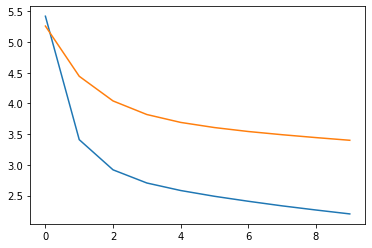

In [85]:
tst2 = MAML()
tst2.train(1, num_tasks, num_grad_steps, meta_lr, step_lr)

tasks = [SineTask() for t in range(20)]

trained = []
untrained = []

for task in tasks:
    # should get same data
    ell1 = tst.fine_tune(task) 
    trained.append(ell1)
    ell2 = tst2.fine_tune(task)
    untrained.append(ell2)

trained_agg = np.mean(trained, axis=0)
untrained_agg = np.mean(untrained, axis=0)

plt.plot(trained_agg)
plt.plot(untrained_agg)

In [55]:
diag

tensor([0.5502])

In [48]:
name = 'relasdfsadf1'

In [49]:
name[:-1]

'relasdfsadf'

In [190]:
a = torch.Tensor([[2,3,6,4,8]])
b = torch.Tensor([[1,9,8,9,8]])
c = torch.cdist(a,b)

dist = np.linalg.norm(a.numpy()-b.numpy())
print(c)
dist

tensor([[8.1240]])


8.124039

In [165]:
1+36+4+25+0


66

In [191]:
np.sqrt(66)

8.12403840463596